In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from scipy.stats import norm 

ModuleNotFoundError: No module named 'scipy'

In [3]:
from datetime import datetime, time
import pandas_datareader.data as pdr
import yfinance as yf

In [116]:
def black_scholes(s0, k, r, t, sigma, option_type):
    T = t/252  #daily to yearly 
    s = s0 * np.exp(-sigma*T)
    d1 = (np.log(s/k) + ((r + sigma**2/2)*T))/ (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    n_d1 = norm.cdf(-d1)
    n_d2 = norm.cdf(-d2)
    
    
   
    if option_type == 'Call':
        value = s * norm.cdf(d1) - k * np.exp(-r*T) * norm.cdf(d2) 
        #return c
    else:
        value =  k * np.exp(-r *t)* n_d2 - s * n_d1
        #return p
    
    # calculating break even point
    if option_type == 'Call': 
        bep = k + value
    else:
        bep = k - value
        
    #delta
    if option_type == 'Call' : delta = norm.cdf(d1) 
    else:  delta = norm.cdf(d1) -1
    
    #gamma
    gamma = norm.pdf(d1) /(s * sigma * np.sqrt(T))
    
    #theta
    if option_type =='Call':
        theta = -((s * norm.pdf(d1)*sigma)/(2*np.sqrt(T))) - r * k *np.exp(-r*T)*norm.cdf(d2)
    else:
        theta = -((s * norm.pdf(d1)*sigma)/(2*np.sqrt(T))) + r * k* np.exp(-r*T)*n_d2
    
    #vega
    vega = s* np.sqrt(T) * norm.pdf(d1)
    
    #rho
    if option_type == 'Call':
        rho = k * T * np.exp(-r*T)*norm.cdf(d2)
    else:
        rho = -(k * T * np.exp(-r*T)*n_d2)
    
    option_values = {
        "option_type" : option_type,
        "premium" : value.round(4), "Breakeven point": bep.round(4),  "detla" :  delta.round(4), "gamma" : gamma.round(4), 
        "theta" : theta.round(4), "vega" : vega.round(4),'rho' :  rho.round(4)       
    }
    
    return option_values

##### Ticker and expiry date

In [78]:
ticker = 'QCOM'
expiry_date = '12-15-2023'


In [79]:
today = datetime.now().date()
one_year_ago = today.replace(year = today.year-1)

In [80]:
stock = yf.Ticker(ticker)
df = yf.download(ticker,start = one_year_ago, end = today,rounding = True )


[*********************100%***********************]  1 of 1 completed


In [81]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-21,121.09,122.50,120.10,120.20,117.07,8204200
2022-11-22,120.84,123.79,120.03,123.65,120.43,7010200
2022-11-23,123.54,127.04,123.29,125.15,121.89,5481500
2022-11-25,124.86,125.36,123.40,123.45,120.23,3153800
2022-11-28,122.16,123.45,118.85,119.54,116.42,7087500


In [82]:
df_1 = df['Adj Close']
df_returns = df_1.to_frame()

In [83]:
#calculating returns
df_returns['returns'] = df['Adj Close'].pct_change()

In [84]:
df_returns['cum_ret'] = (df_returns['returns'] +1).cumprod()


In [85]:
df_returns.dropna().head()

,Adj Close,returns,cum_ret
Date,,,
2022-11-22,120.43,0.028701,1.028701
2022-11-23,121.89,0.012123,1.041172
2022-11-25,120.23,-0.013619,1.026992
2022-11-28,116.42,-0.031689,0.994448
2022-11-29,115.29,-0.009706,0.984795


In [86]:
log_returns = np.log(df['Close']/df['Close'].shift(1)).dropna()


In [87]:
df_returns['log_returns'] = log_returns
df_returns.tail()

,Adj Close,returns,cum_ret,log_returns
Date,,,,
2023-11-13,123.85,-0.002898,1.057914,-0.002903
2023-11-14,127.36,0.028341,1.087896,0.027947
2023-11-15,128.92,0.012249,1.101221,0.012174
2023-11-16,128.70,-0.001706,1.099342,-0.001708
2023-11-17,129.47,0.005983,1.105920,0.005965


#### Plotting returns

<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

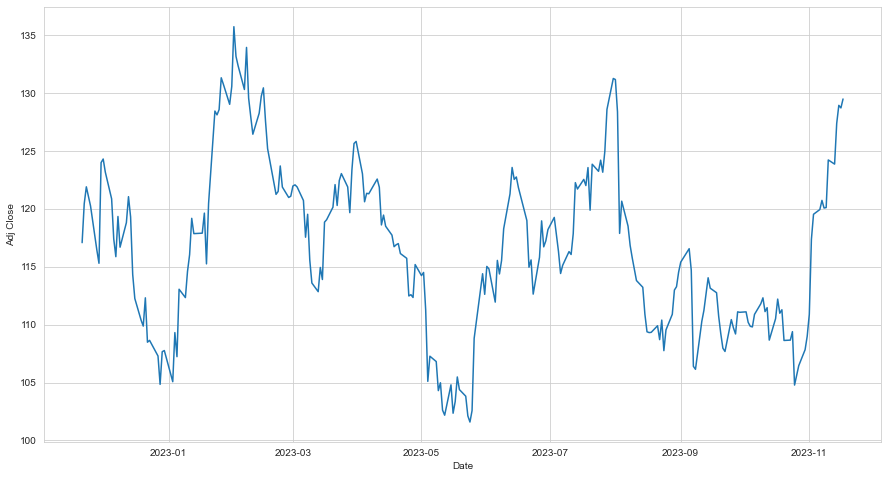

In [88]:
#Visualize the price
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
sns.lineplot(data = df_returns['Adj Close'] )

<AxesSubplot:xlabel='Date', ylabel='returns'>

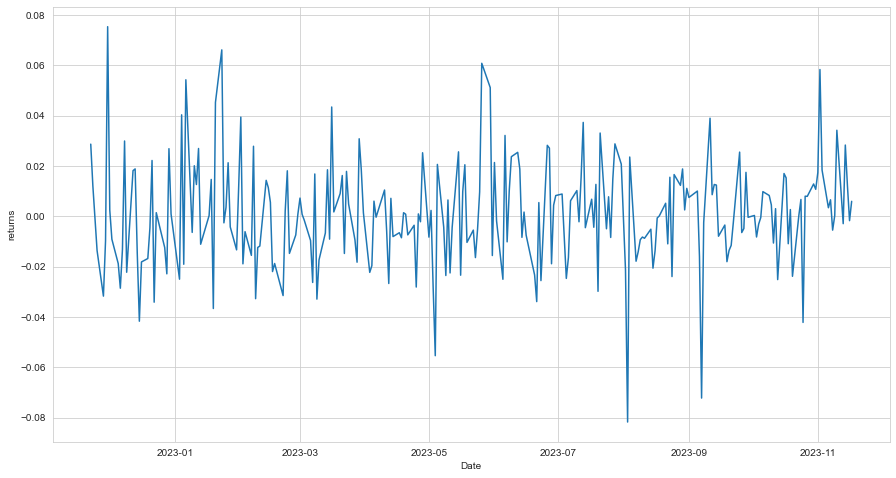

In [89]:
#Visualizing log return
plt.figure(figsize=(15,8))
sns.lineplot(data = df_returns['returns'])

<AxesSubplot:xlabel='returns', ylabel='Count'>

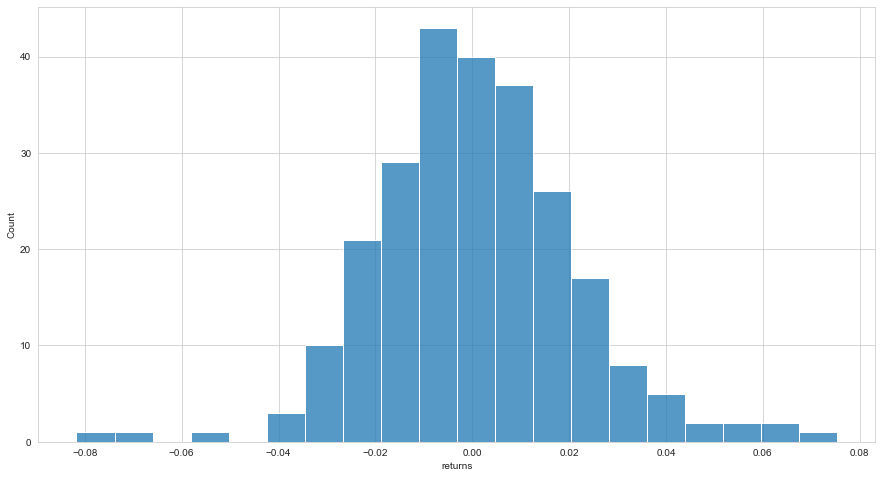

In [90]:
#Visualizing return
plt.figure(figsize=(15,8))
sns.histplot(data = df_returns['returns'])

##### Sigma 

In [91]:
sigma = np.sqrt(252)*(df_returns['log_returns'].std())
sigma

0.33478410124810876

In [92]:
sigma_ret = np.sqrt(252)*(df_returns['returns'].std())
sigma_ret

0.33610387266748754

#### Risk-free rate

In [93]:
#risk-free rate, as the 6 month U.S. treasury yield which could get from ^TNX
r = 0.0539

#### Current stock price

In [94]:
#current stock price
s = df_returns['Adj Close'].iloc[-1]
s

129.47

#### Time

In [102]:
# time remaining untill expiration in days
t = (datetime.strptime(expiry_date, "%m-%d-%Y") - datetime.utcnow()).days 
t

24

#### Strike price

In [103]:
strike_price = 130
#sigma = 0.21842

#### Calculating option value

In [117]:
black_scholes(s, strike_price, r, t, sigma,'Call')

{'option_type': 'Call',
 'premium': 2.3251,
 'Breakeven point': 132.3251,
 'detla': 0.3977,
 'gamma': 0.0451,
 'theta': -19.9027,
 'vega': 15.0954,
 'rho': 4.5812}

#### Calculating probability of profit

POP = N[d2(S1)] - N[d2(S2)] 
where S1 < S2; N - cumulative distribution function assuming normal distribution

In [118]:
def d2_norm_cdf(s,k,sigma, r, t):
    T = t/252
    d2 = -(np.log(k/s) - (r - (sigma**2))*T) / (sigma * np.sqrt(T))
    return norm.cdf(d2)
    

In [119]:
s1 = 133.36
s2 = 136.85

In [120]:
#calculating probabiltiy of profit
pop = (d2_norm_cdf(s2,strike_price,sigma,r,t) - d2_norm_cdf(s1,strike_price,sigma,r,t))*100
print(" Probability of Profit is .{0:8.4f}%".format(pop) )

 Probability of Profit is . 12.8778%


In [121]:
from optionlab import black_scholes 

ModuleNotFoundError: No module named 'optionlab'